# CS156 Session 8.1 Pre-class Work
Gaussian Processes

### Import Packages

In [98]:
import GPy
GPy.plotting.change_plotting_library('plotly_offline')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## 1. Iterative Predictions
Write a function to generate synthetic data which is more meaningful than pure random noise (e.g. a sine function with noise added to it). Choose a covariance function that is sensible for your synthetic data.

Write a program that shows the following steps:
1. Observes a new synthetic datapoint
2. Plots the entire dataset, and 10 samples of the posterior Gaussian Process
3. Pauses for 5 seconds
4. Goes to 1 and repeats

### Creating Synthetic Data

In [38]:
#Function to create synthetic data
synth_data_generator = lambda x,n: np.sin(x) + np.random.randn(n,1)*0.05

#Create synthetic (test) data using the function
X = np.random.uniform(-5,5,(10,1))
Y = synth_data_generator(X,len(X))

### Writing the Program

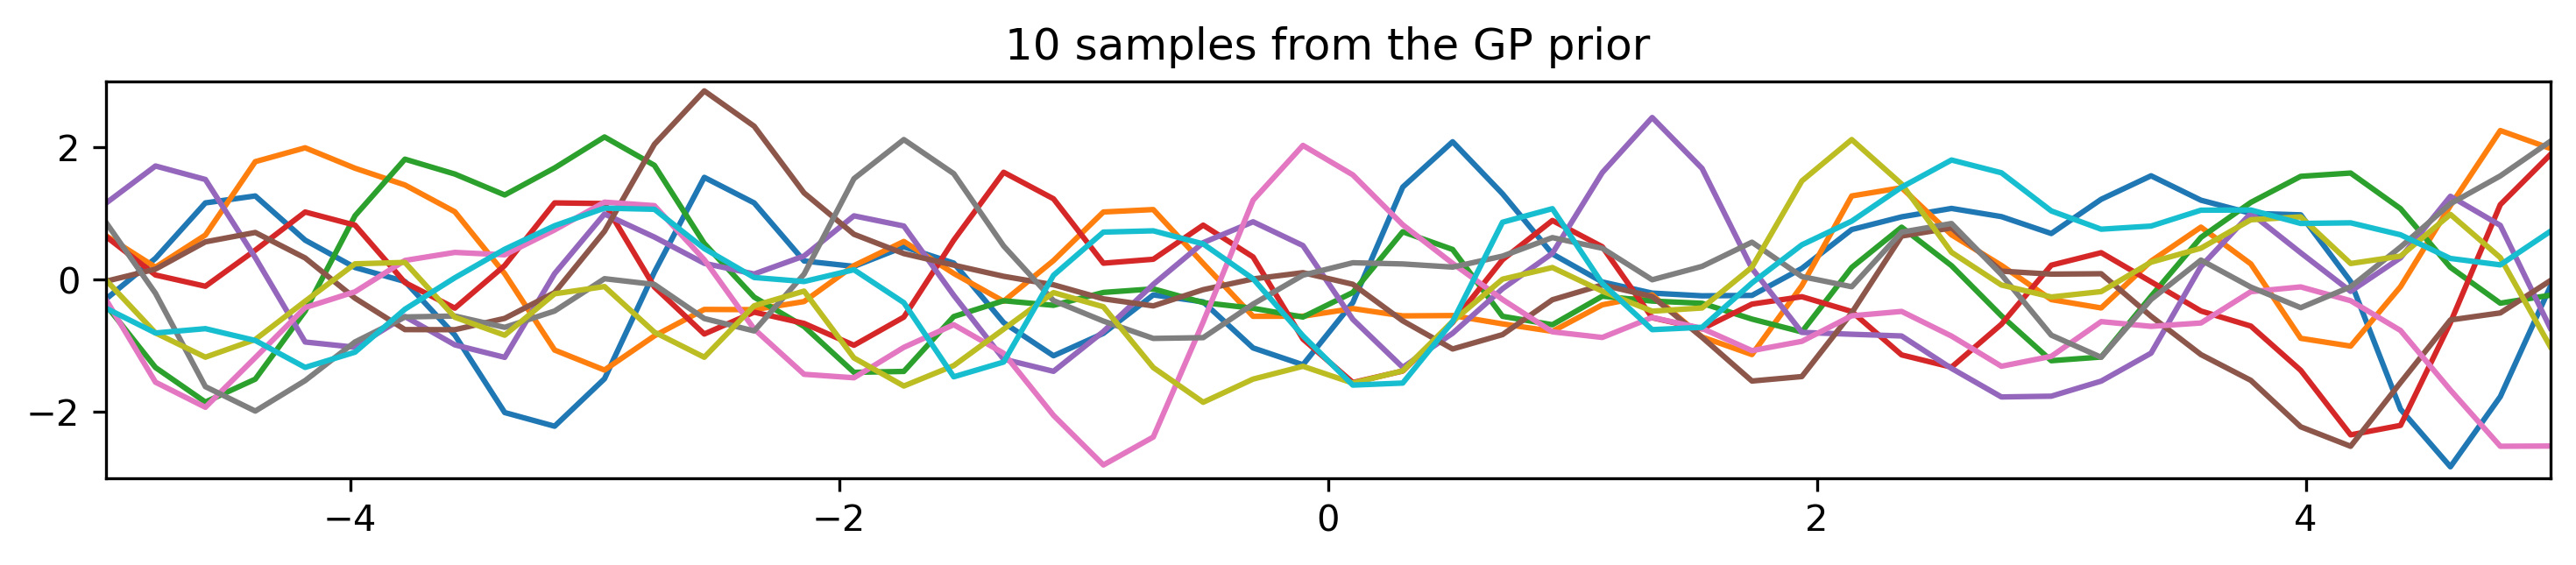

In [40]:
"""
Code adapted from Bailey, K. (2019). Gaussian Processes for Dummies. 
Retrieved from Github.io. https://katbailey.github.io/post/gaussian-processes-for-dummies/
"""

#Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))

# Sample 10 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,10)))

#Plot the 10 sampled functions
plt.figure(figsize=(12, 2), dpi=300)
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('10 samples from the GP prior')
plt.show()


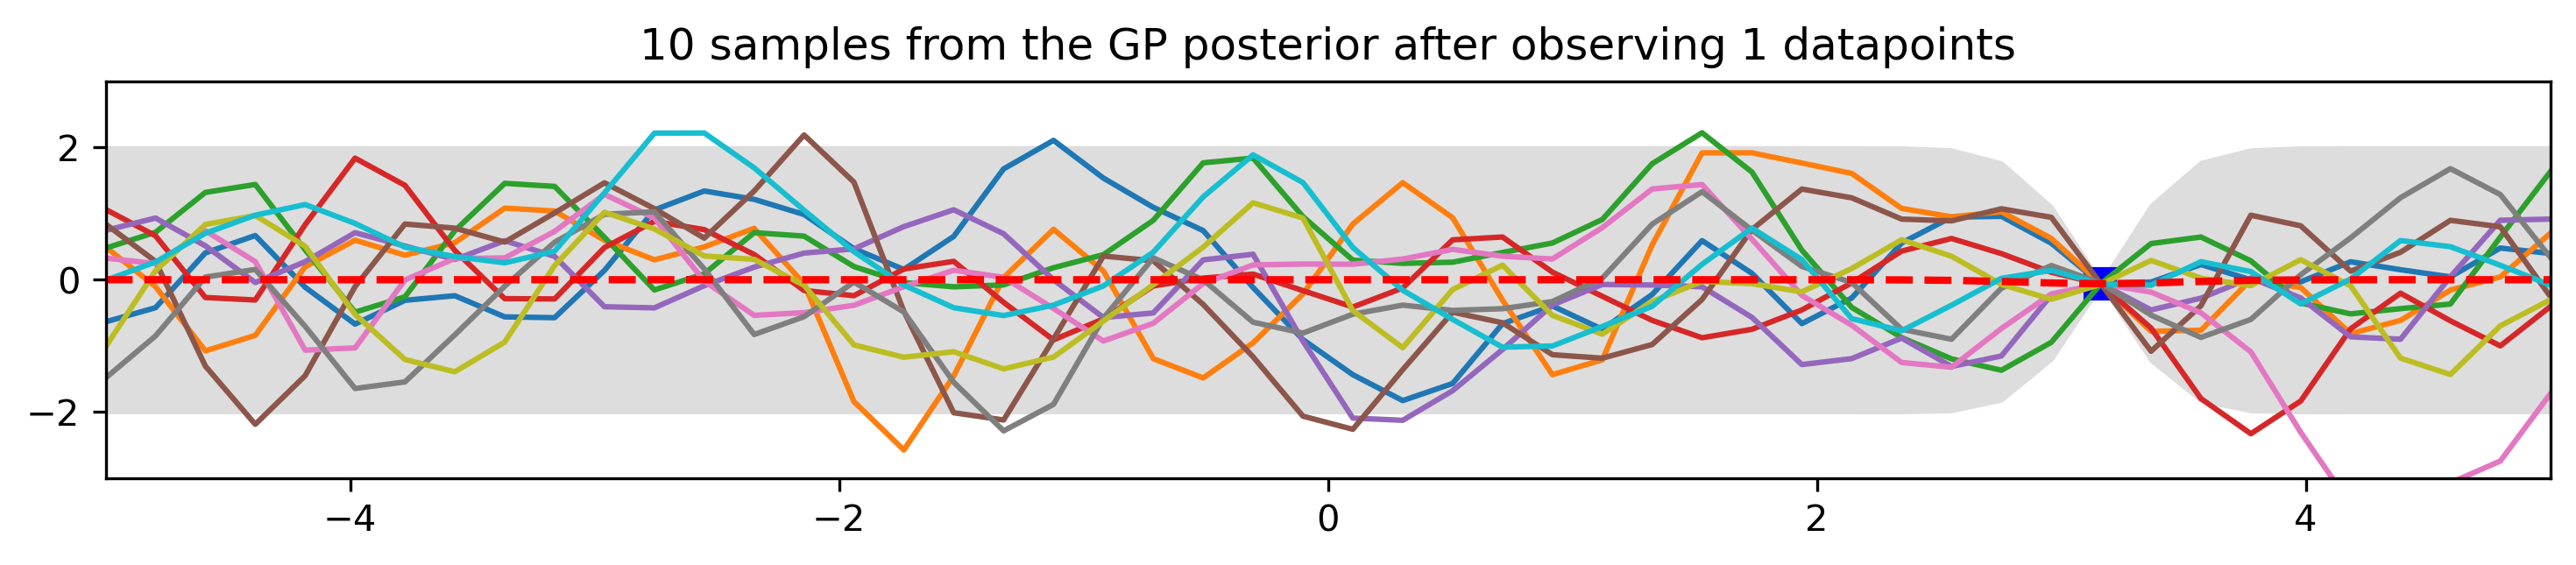

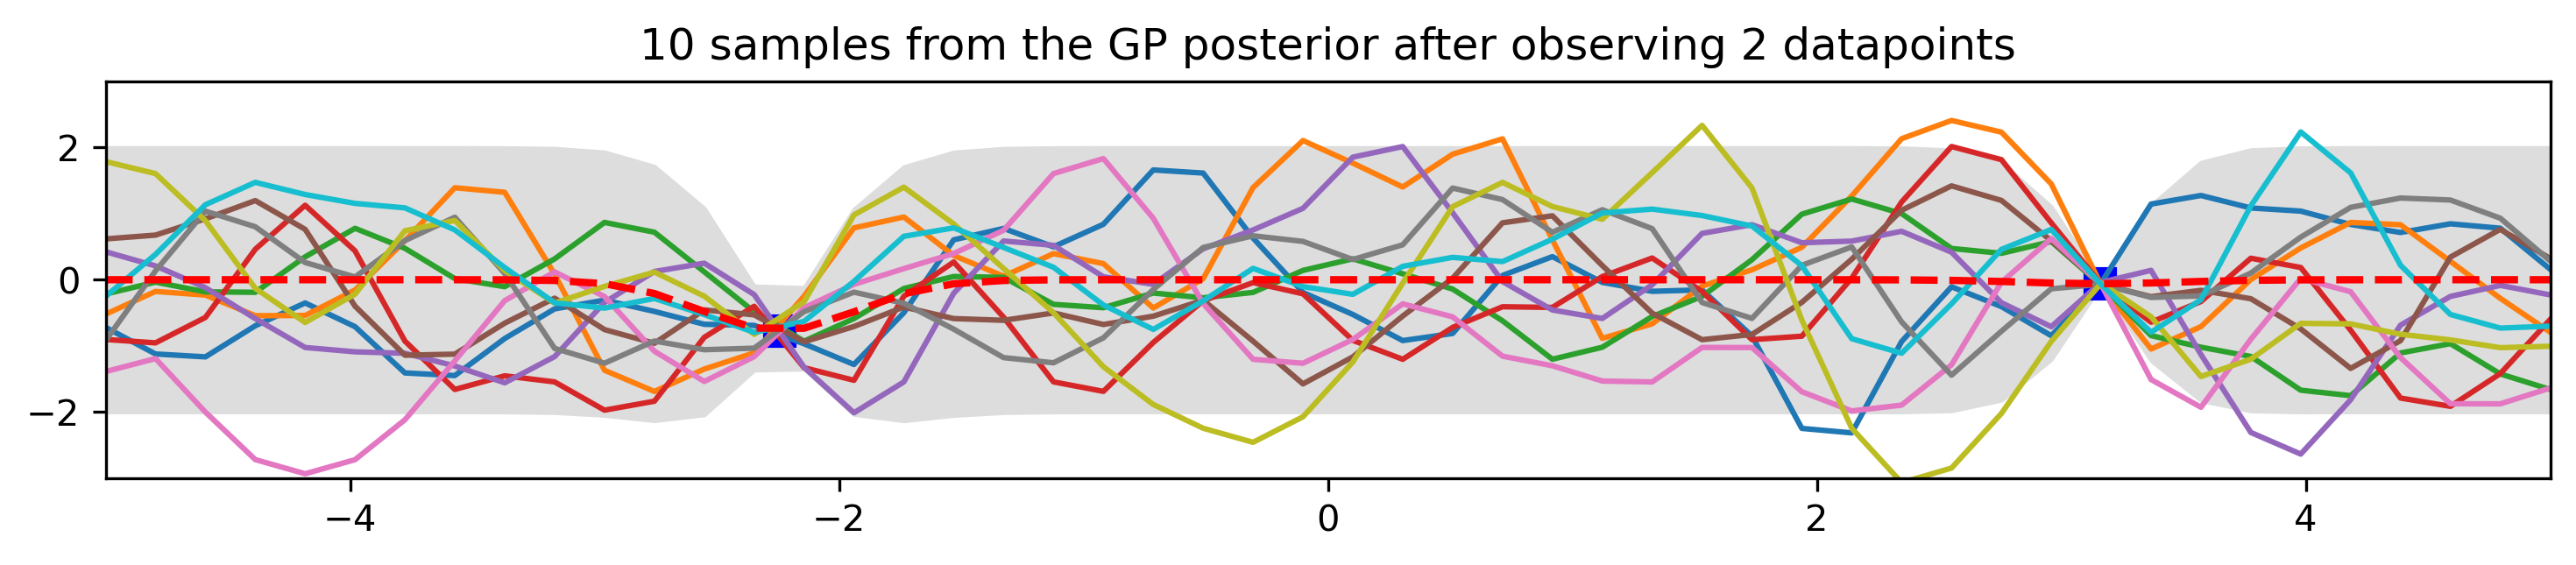

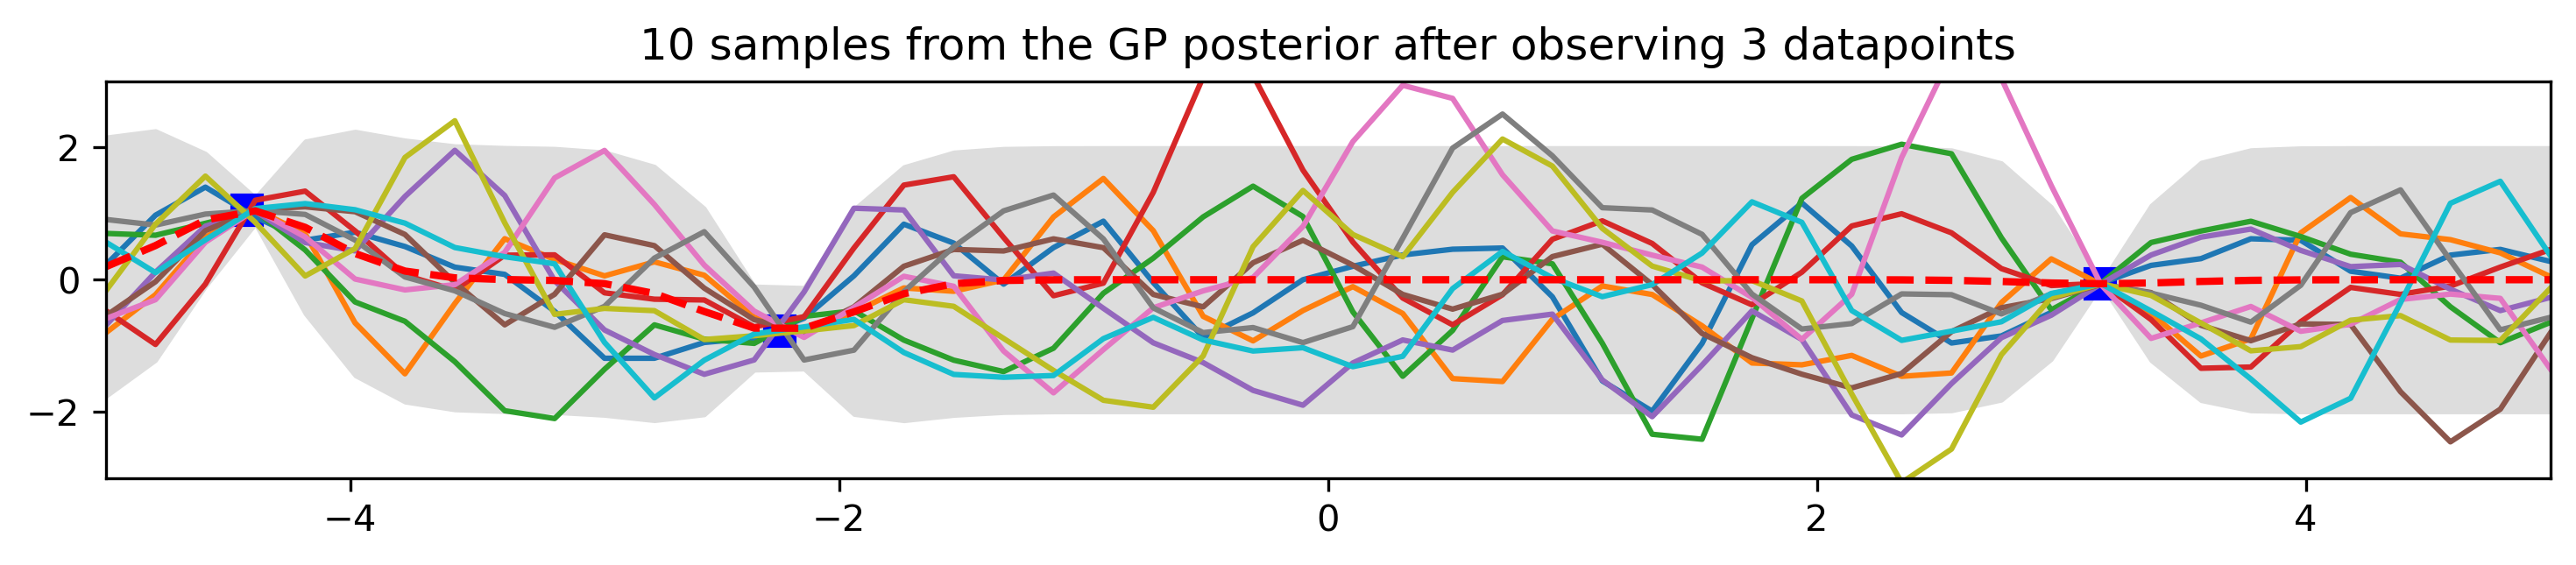

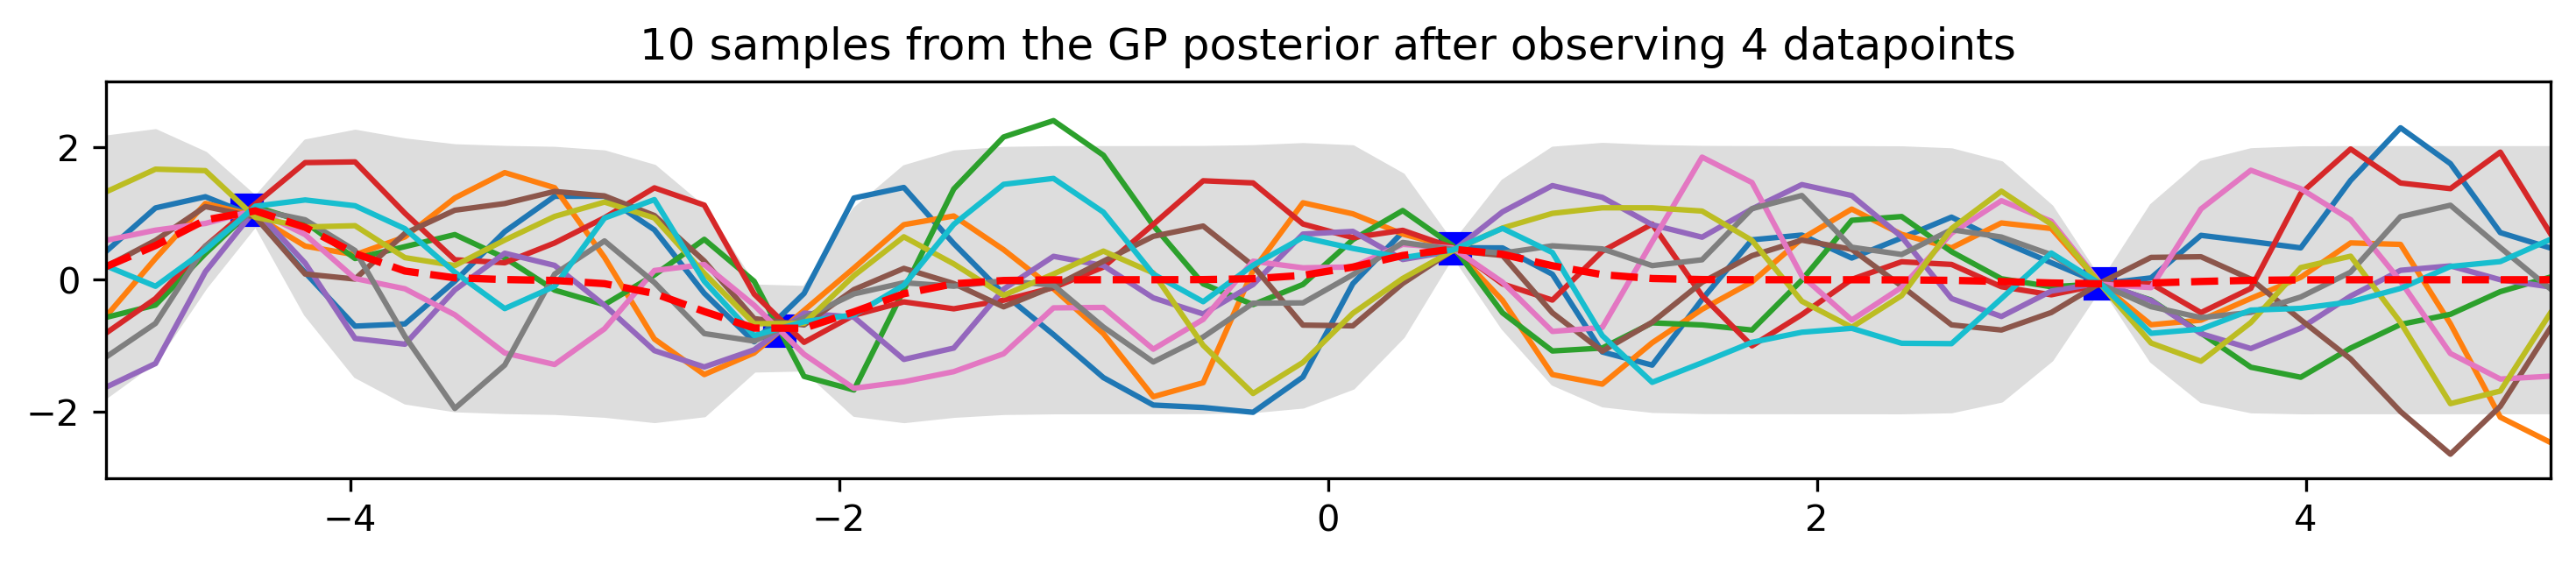

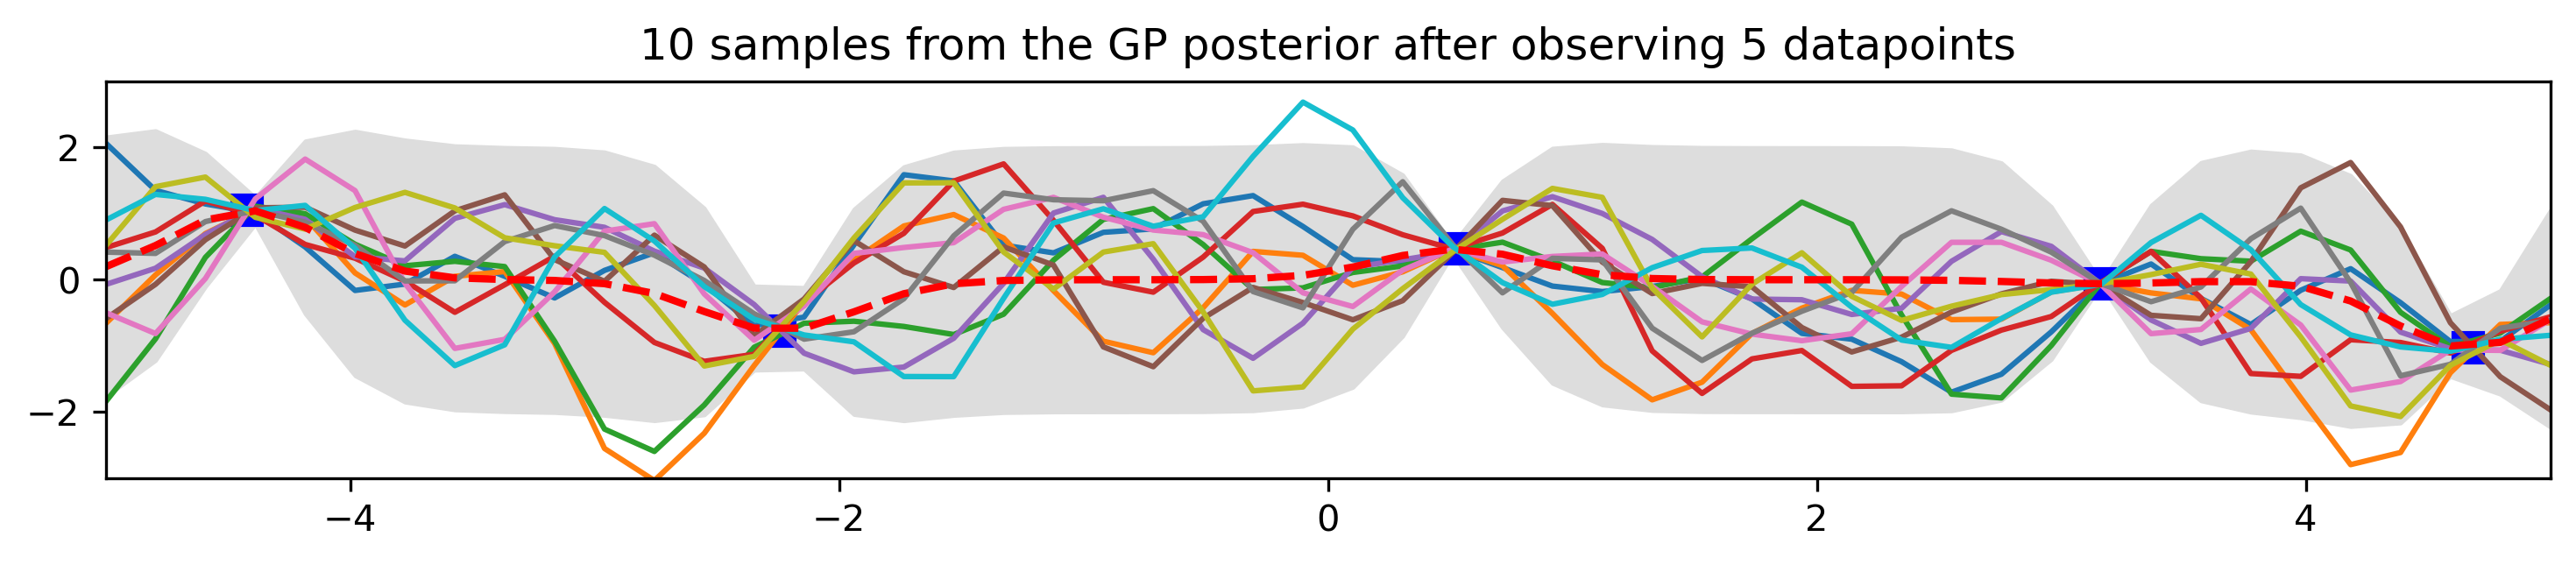

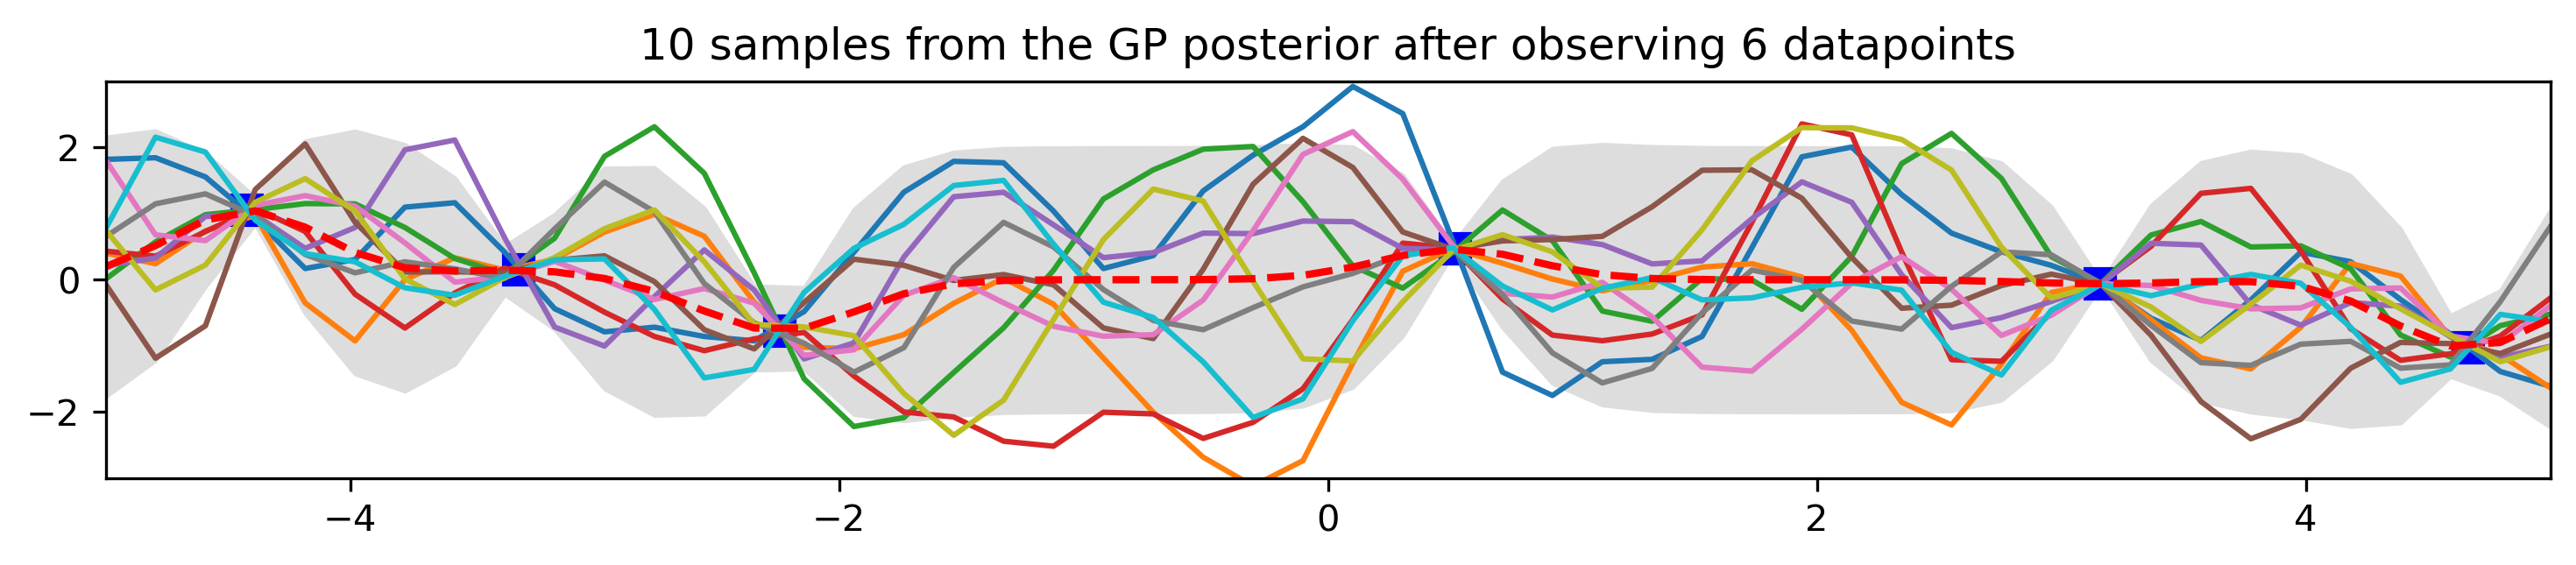

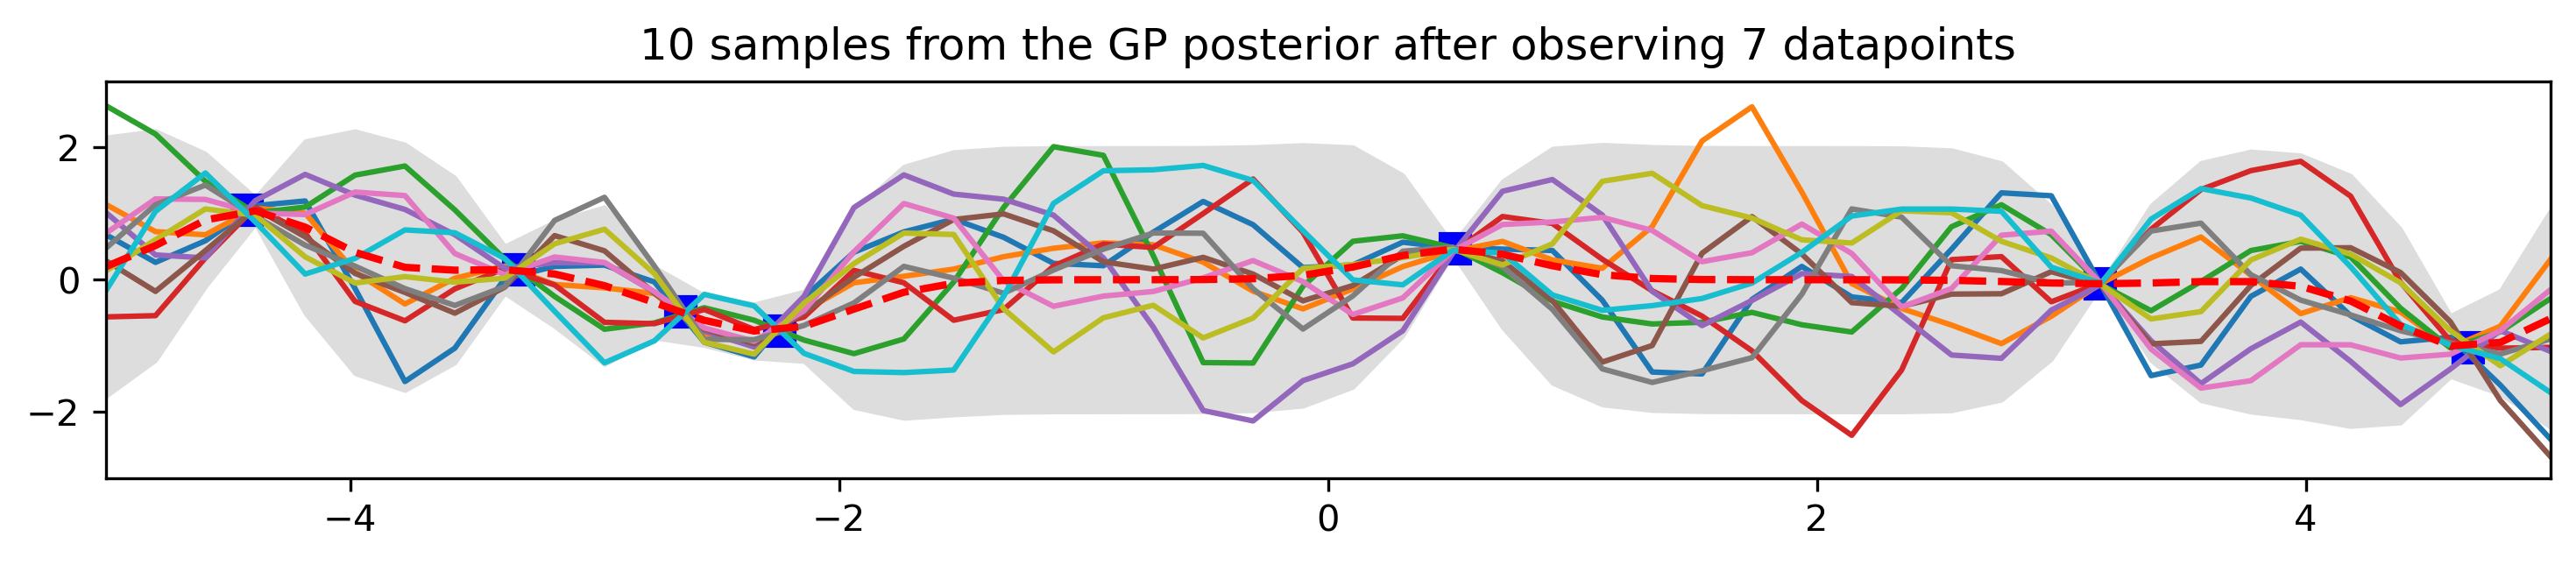

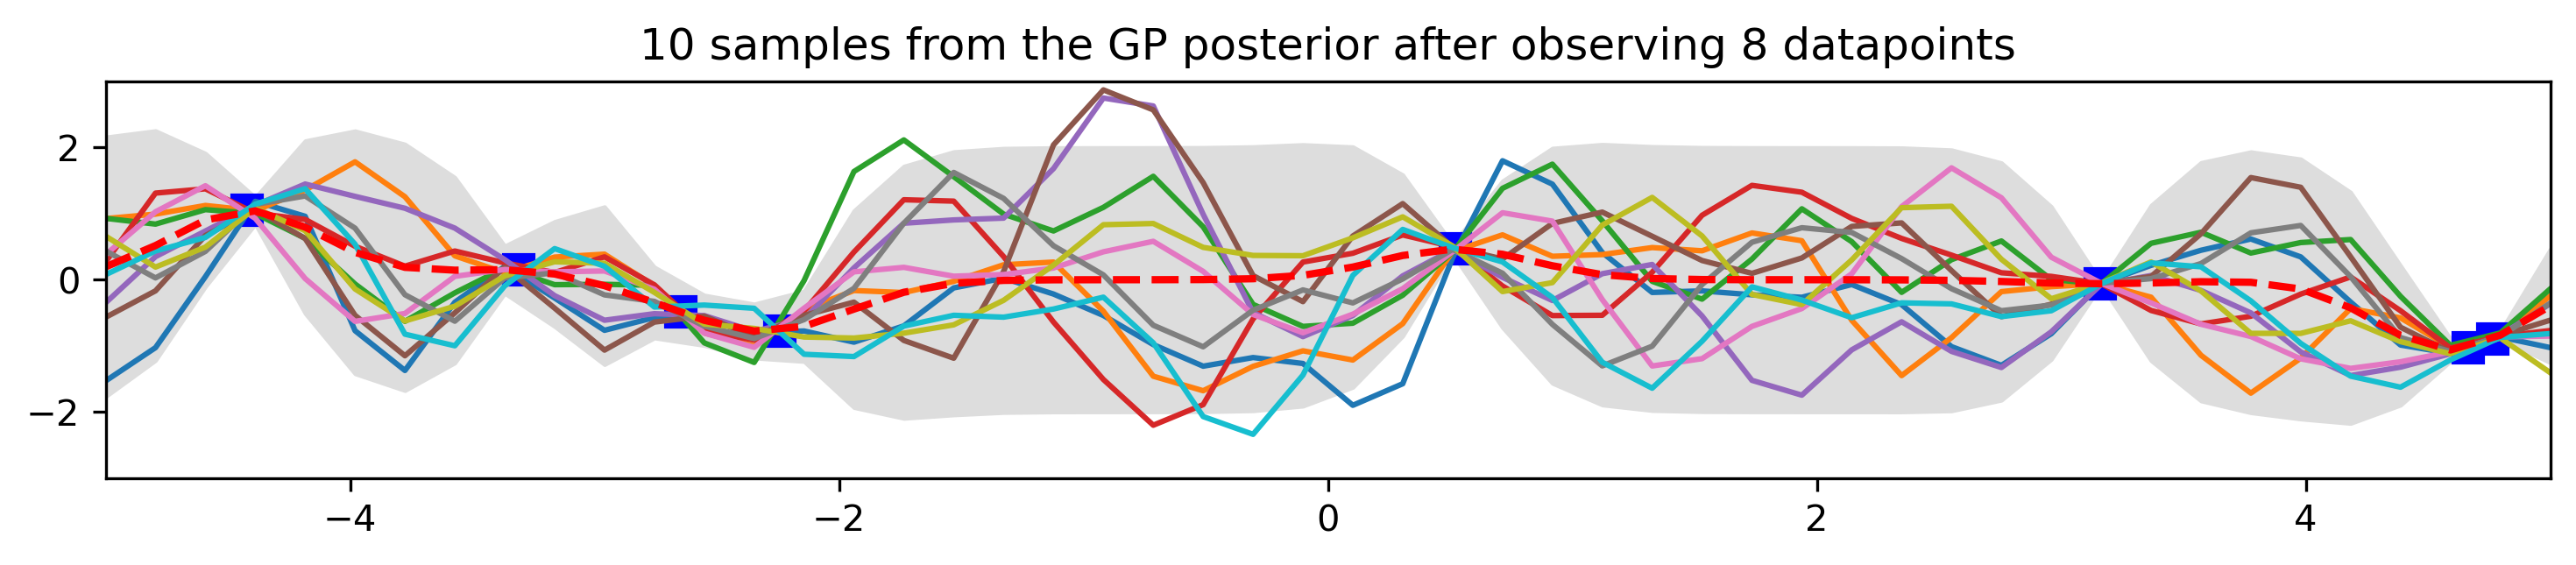

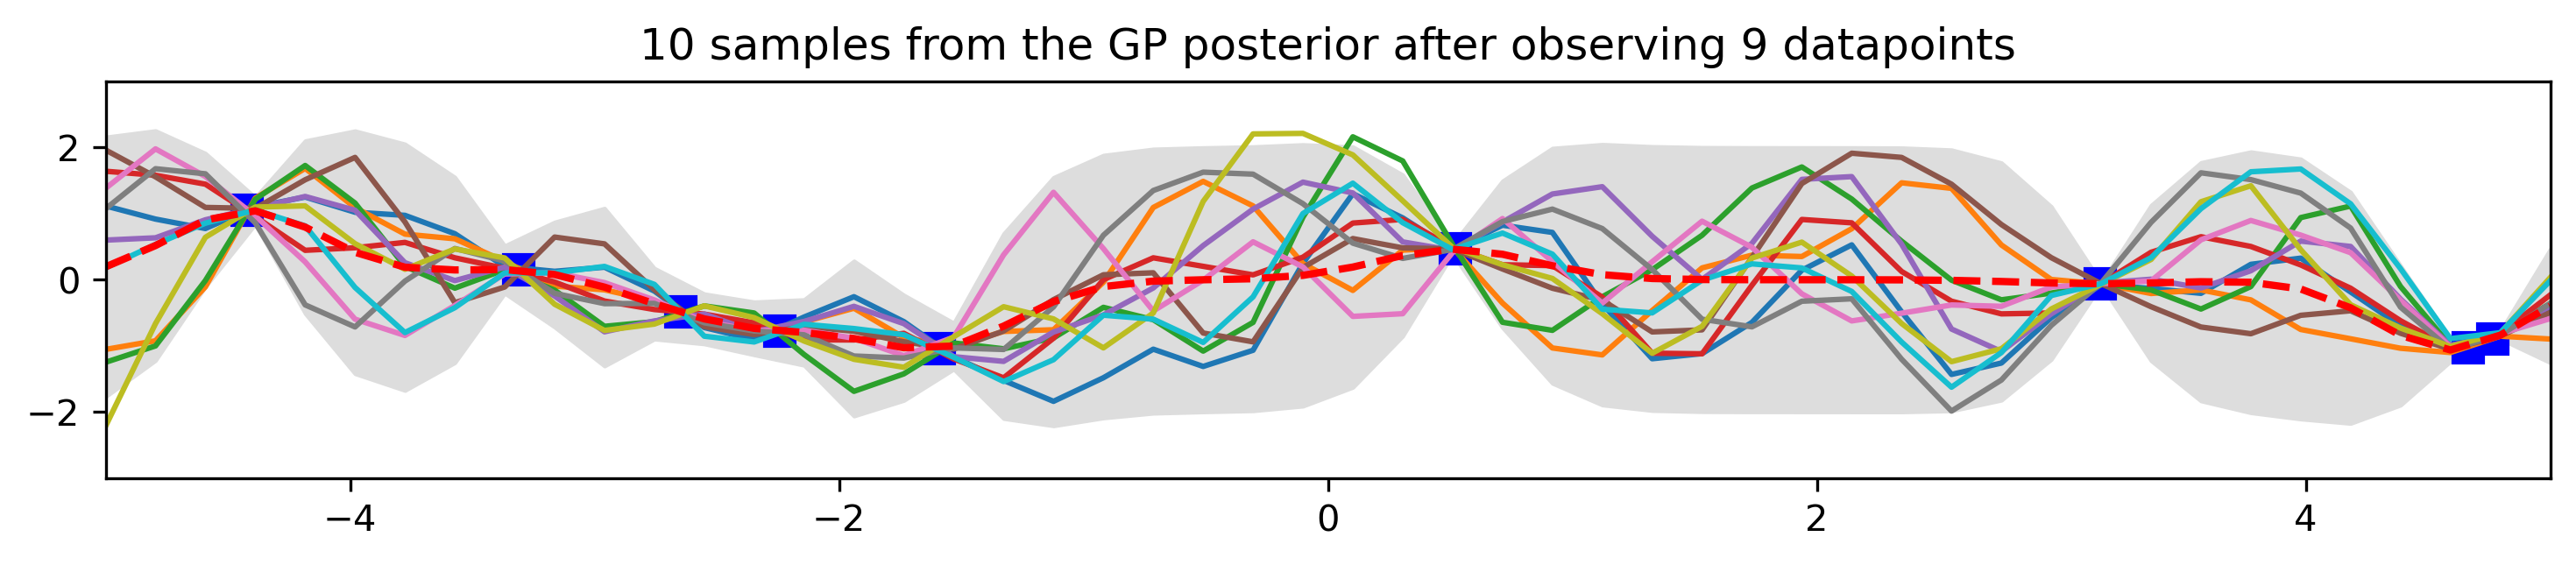

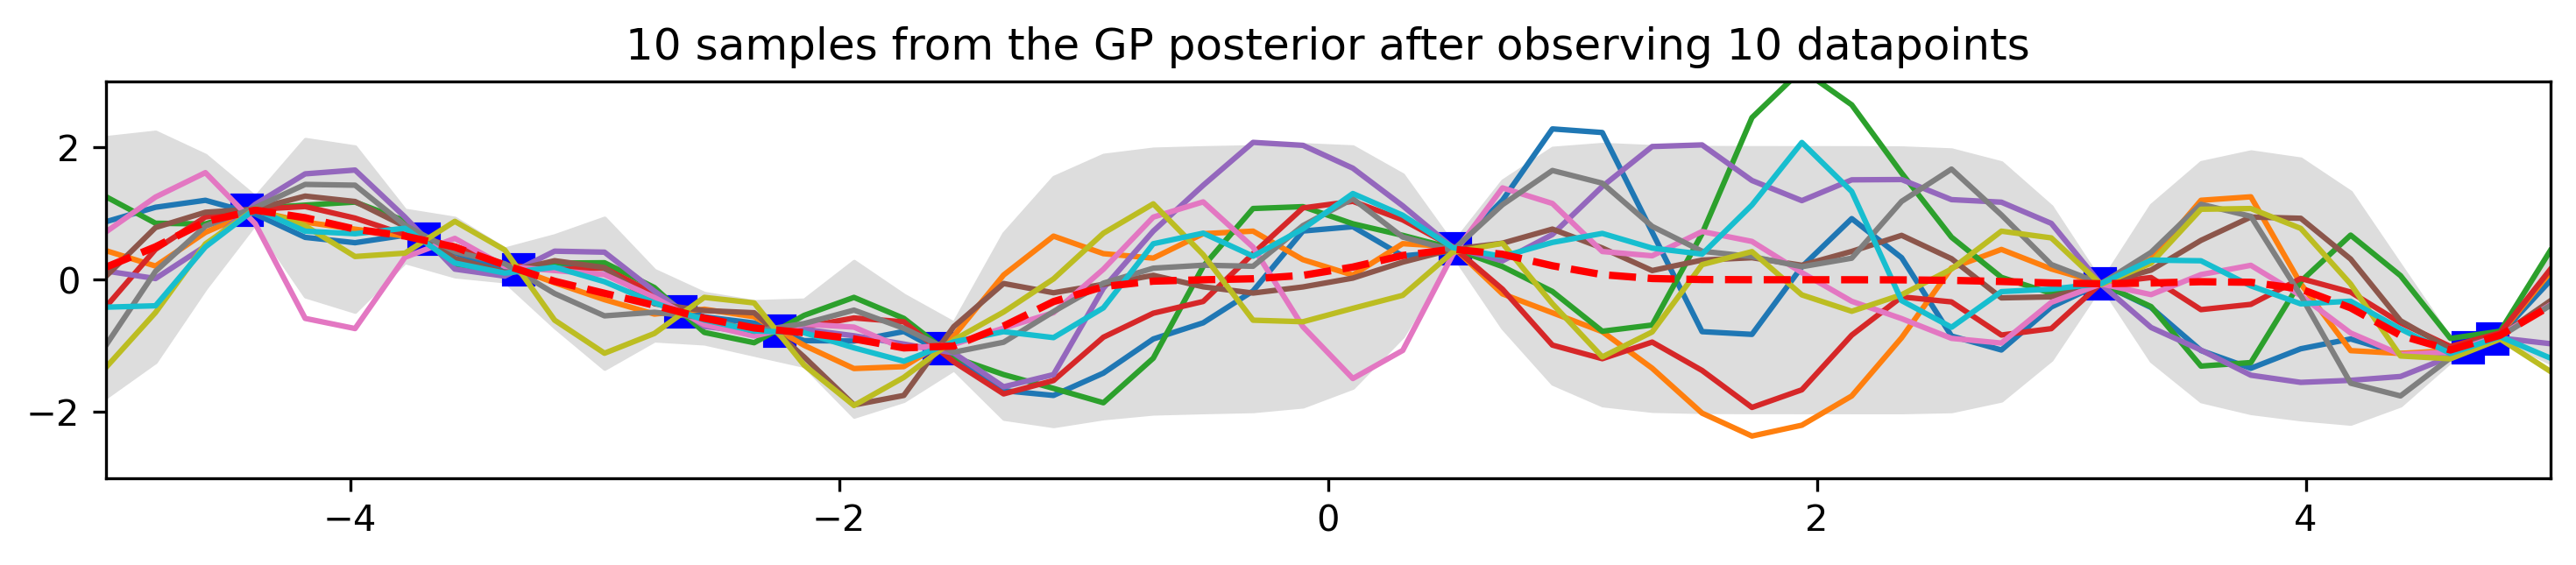

In [46]:
"""
Code adapted from Bailey, K. (2019). Gaussian Processes for Dummies. 
Retrieved from Github.io. https://katbailey.github.io/post/gaussian-processes-for-dummies/
"""

#Training data – Our synthetic data
X_train = X.copy()
y_train = Y.copy()

#List to store the observed datapoints
observed_xs = []
observed_ys = []

#Iterate through all the datapoints
for idx in range(len(X)):
    
    #Randomly pick an datapoint from the data and delete after
    X_idx = np.random.choice([*range(len(X_train))])
    Xtrain = X_train[X_idx].reshape(1,1)
    ytrain = y_train[X_idx].reshape(1,1)
    X_train, y_train = np.delete(X_train,X_idx), np.delete(y_train,X_idx)
    
    #Note which datapoints have been observed
    if observed_xs == []:
        observed_xs = Xtrain
        observed_ys = ytrain
    else:
        observed_xs = np.vstack([observed_xs, Xtrain])
        observed_ys = np.vstack([observed_ys, ytrain])

    #Apply the kernel function to our training points
    K = kernel(observed_xs, observed_xs, param)
    L = np.linalg.cholesky(K + 0.00005*np.eye(len(observed_xs)))

    #Compute the mean at our test points.
    K_s = kernel(observed_xs, Xtest, param)
    Lk = np.linalg.solve(L, K_s)
    mu = np.dot(Lk.T, np.linalg.solve(L, observed_ys)).reshape((n,))

    #Compute the standard deviation so we can plot it
    s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
    stdv = np.sqrt(s2)
    
    # Draw samples from the posterior at our test points.
    L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
    
    #Plot the datapoints and 10 samples of the posterior Gaussian Process
    plt.figure(figsize=(12, 2), dpi=300)
    plt.plot(observed_xs, observed_ys, 'bs', ms=8)
    plt.plot(Xtest, f_post)
    plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
    plt.plot(Xtest, mu, 'r--', lw=2)
    plt.axis([-5, 5, -3, 3])
    plt.title(f'10 samples from the GP posterior after observing {idx+1} datapoint(s)')
    plt.show()
    
    #Pause for 5 seconds
    time.sleep(5)

## 2. CO₂ Concentration
A great example of the power of Gaussian Processes is the modeling of the CO₂ concentration in the atmosphere. Using the data as specified [here](http://learning.eng.cam.ac.uk/carl/mauna/), write some Python code to fit this data using the GPy library. There are several suggestions for the best covariance function for this dataset available on the internet. A good explanation of one such suggestion is given [here](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html), however, you are free to choose a simple covariance function and evaluate how good a job it is able to do.

In [62]:
co2_data = np.loadtxt('co2_mm_mlo.txt')
co2_df = pd.DataFrame(co2_data)
co2_df.head()

0    1          2       3       4    5     6     7
0  1958.0  3.0  1958.2027  315.70  314.43 -1.0 -9.99 -0.99
1  1958.0  4.0  1958.2877  317.45  315.16 -1.0 -9.99 -0.99
2  1958.0  5.0  1958.3699  317.51  314.71 -1.0 -9.99 -0.99
3  1958.0  6.0  1958.4548  317.24  315.14 -1.0 -9.99 -0.99
4  1958.0  7.0  1958.5370  315.86  315.18 -1.0 -9.99 -0.99

In [177]:
X = co2_df.iloc[:,2].values.reshape(-1,1)
y = co2_df.iloc[:,3].values.reshape(-1,1)

### Define the covariance kernel for the model

In [222]:
"""
Adapted from https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html
"""
kernel_1 = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=41.8)
kernel_2 = GPy.kern.RBF(input_dim=1, lengthscale=180)
kernel_3 = GPy.kern.PeriodicExponential(lengthscale=1.44)

kernel = kernel_1 + kernel_2 + kernel_3

In [223]:
m = GPy.models.GPRegression(X, y, kernel)

In [224]:
from IPython.display import display
display(m)

In [225]:
fig = m.plot()
#fig[0].update_layout(xaxis=dict(range=[X.min(),X.max()]))
GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

In [226]:
m.optimize(messages=True)

In [227]:
display(m)
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')